In [247]:
from tensorflow.keras.metrics import CategoricalAccuracy
import tensorflow as tf
from data_loader import get_loader
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np
from models.distances import Euclidean_Distance
from models.stn import BilinearInterpolation,Localization
from sklearn.neighbors import KNeighborsClassifier
from time import time
import os
from models.metrics import accuracy
from tensorflow.keras.metrics import Mean
from sklearn.metrics.pairwise import euclidean_distances as dist

In [2]:
def standardize(img):
    mean = np.mean(img)
    std = np.std(img)
    return (img - mean) / std

In [3]:
loaded_encoder = keras.models.load_model(
    'model_files/best_encoders/densenet_gtsrb2tt100k_encoder.h5',
    custom_objects={'BilinearInterpolation':BilinearInterpolation,'Localization':Localization},compile=True)

2023-02-11 20:15:37.141538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 20:15:37.601891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10020 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [131]:
loader = get_loader('gtsrb2tt100k') 
_,test_generator = loader.get_generator(batch=128,dim=64)

Loading 43 all data from datasets/GTSRB
Loading 36 all data from datasets/TT100K


In [265]:
t = iter(test_generator)
[Xs,Xq],y = next(t)
n_cls = len(Xs)
auc = np.empty((n_cls,1))
retreival_img = np.empty((n_cls,64,64,3))
number_of_averaging_retrieval = 100
for i in range(36):
    z = loaded_encoder(tf.expand_dims(Xs[i],axis=0))
    IM = []
    D = []
    lab = []
    pb = tf.keras.utils.Progbar(len(test_generator),verbose=1)
    for data in test_generator:
        [Xs,Xq],y = data
        Zq = loaded_encoder(Xq)
        for k,zq in enumerate(Zq):
            IM += [Xq[k]]
            #zq = loaded_encoder(tf.expand_dims(x,axis=0))
            D += [dist(zq[None,...],z)[0][0]]
            lab += [y[k]]
        pb.add(1)
    D = np.array(D)
    IM = np.array(IM)
    lab = np.array(lab)
    val,indexes =  tf.nn.top_k(-D,k=number_of_averaging_retrieval,sorted=True)
    y_true = np.expand_dims(to_categorical(i,num_classes=n_cls),axis=0)
    auc[i] = tf.keras.metrics.AUC()(lab[indexes],tf.broadcast_to(y_true,lab[indexes].shape))
    img = IM[indexes]
    retreival_img[i] = tf.reduce_mean(img,axis=0)
    

93/93 [==============================] - 29s 315ms/step


In [266]:
print(f'Average AUC = {tf.reduce_mean(auc):.4f}')

Average AUC = 0.8684


In [267]:
import matplotlib.pyplot as plt

In [268]:
def normalize(img):
    return ((img - np.min(img))/(np.max(img) - np.min(img)))

In [269]:
def plot_multi_line(Xs,size=15,font_size=5,hspace=0.1,col_num=10):
    fig, axes = plt.subplots(nrows=12,ncols=6,
            figsize=(size,size),subplot_kw={'xticks': [], 'yticks': []})
    n = 0
    for row in range(0,2*6,2):
        for col in range(6):
            axes[row][col].imshow(normalize(Xs[n]))
            #axes[row][col].set_title(names[n],c="green",size=font_size)
            axes[row+1][col].imshow(normalize(retreival_img[n]))
            n += 1
    plt.tight_layout()
    plt.subplots_adjust(hspace=hspace)
    plt.show()

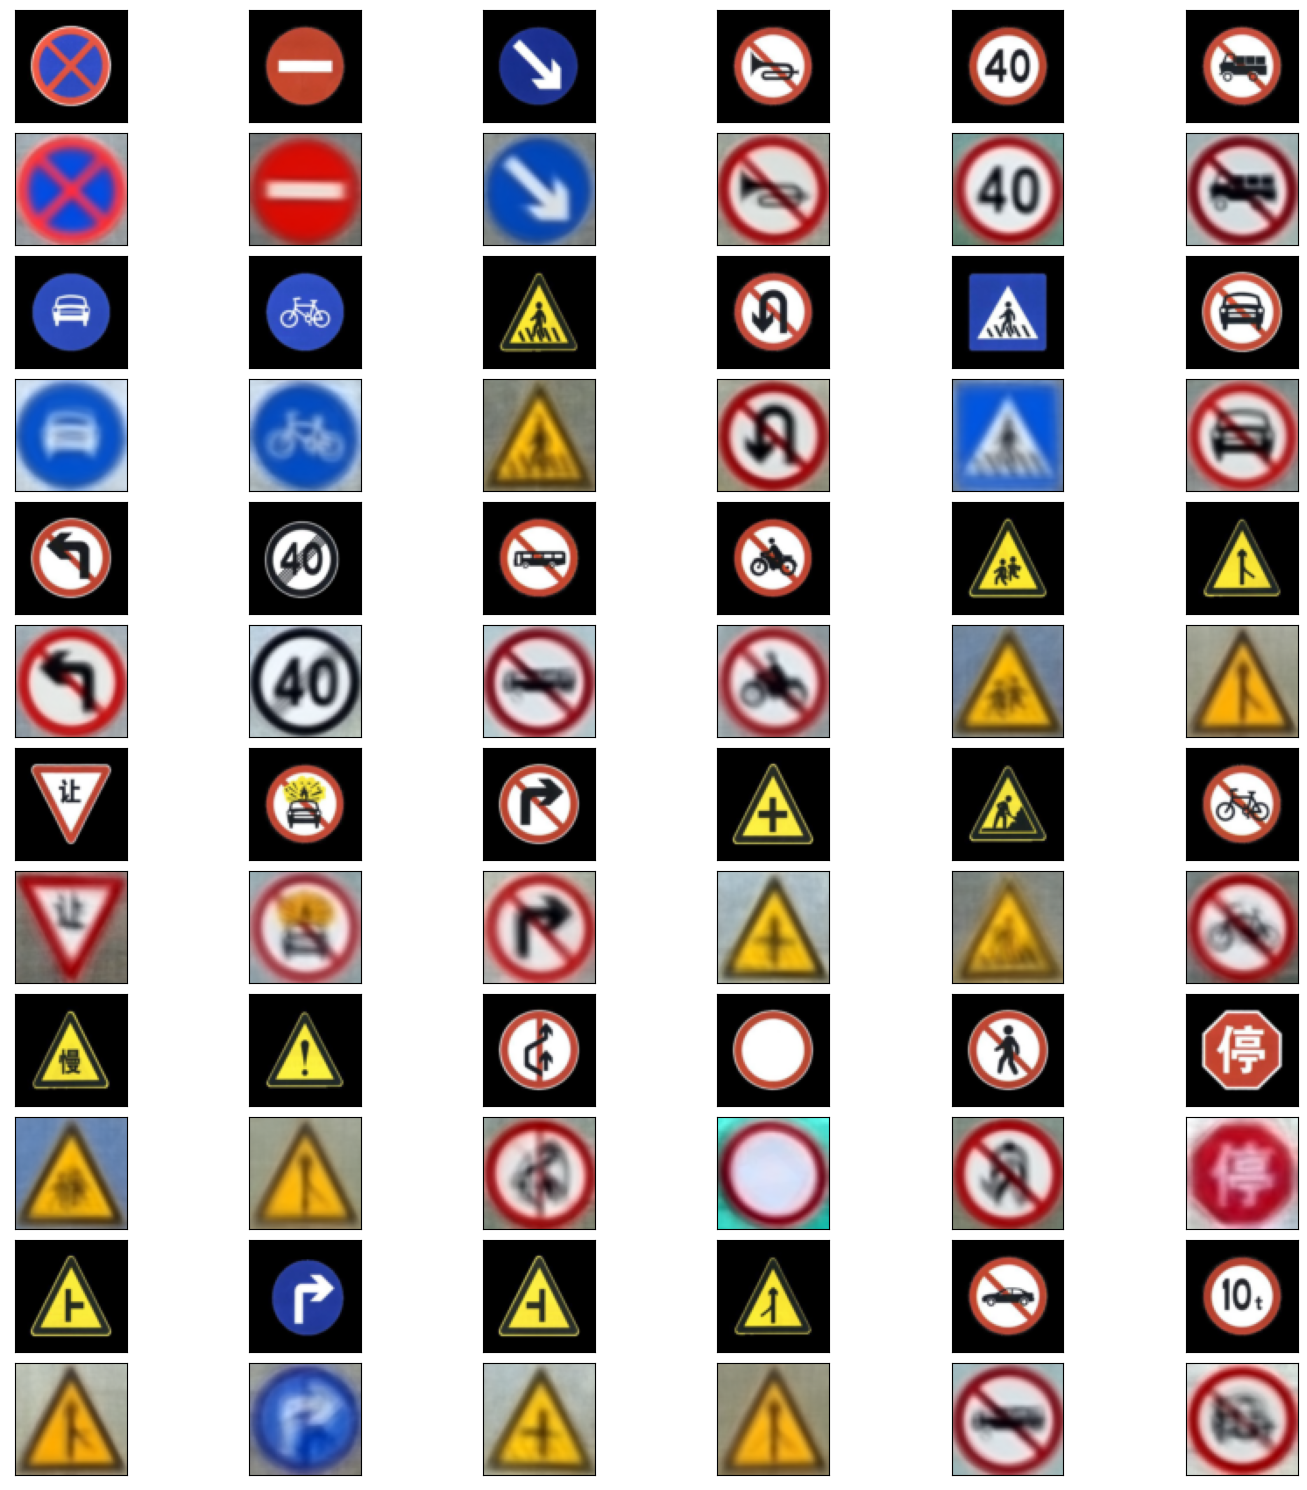

In [270]:
plot_multi_line(Xs)